In [1]:
import tf_keras as keras
from tf_keras import layers
from tf_keras import callbacks # Import for EarlyStopping
import pandas as pd
import tensorflow_probability as tfp
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

tfd = tfp.distributions

In [2]:
# Set a seed value for reproducibility
SEED = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

In [13]:
# Load the .ori orientation file
ori_path = "DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)
ori_df = ori_df.drop(columns=["prefix"])
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Load detector data
time_array = np.load("time_array.npy")
rates = np.squeeze(np.load("total_rates.npy"))
time_series = pd.to_datetime(time_array, unit='s')
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series
rates_df = rates_df[rates_df["timestamp"].dt.hour >= 13]
ori_df = ori_df.dropna(subset=["timestamp"])

# Merge orientation with detector data
merged_df = pd.merge_asof(
    rates_df.sort_values("timestamp"),
    ori_df.sort_values("timestamp"),
    on="timestamp"
).dropna()
merged_df["hour"] = merged_df["timestamp"].dt.hour + merged_df["timestamp"].dt.minute / 60

# remove data with 0 counts and high counts
target_cols = [col for col in merged_df.columns if col.startswith("detector_")]
orientation_features = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
merged_df_no_zeros = merged_df[(merged_df[target_cols] != 0).all(axis=1)]
merged_df_clean = merged_df_no_zeros[(merged_df_no_zeros[target_cols] >= 1000).all(axis=1)]

print("Successfully loaded data from local files.")

C:\Users\mikec\AppData\Local\Temp\ipykernel_10636\35109406.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


Successfully loaded data from local files.


In [19]:
# Extract features (X) and targets (y)
X = merged_df_clean[orientation_features].values.astype(np.float32)
y = merged_df_clean[target_cols].values.astype(np.float32)

# Split data into training and testing sets
split_index = int(len(X) * 0.8)

# Split the data chronologically
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("\nData shapes after splitting and scaling:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")

# Get dimensions from the data
NUM_FEATURES = X_train_scaled.shape[1]
NUM_DETECTORS = y_train_scaled.shape[1]


Data shapes after splitting and scaling:
X_train_scaled shape: (1711, 7)
y_train_scaled shape: (1711, 6)
X_test_scaled shape: (428, 7)
y_test_scaled shape: (428, 6)


In [20]:
PARAMS_PER_DISTRIBUTION = 2
NUM_PARAMS = NUM_DETECTORS * PARAMS_PER_DISTRIBUTION

inputs = keras.Input(shape=(NUM_FEATURES,), name="orientation_features")
hidden = layers.Dense(128, activation='relu')(inputs)
hidden = layers.Dense(64, activation='relu')(hidden)
params = layers.Dense(NUM_PARAMS, activation=None)(hidden)

outputs = tfp.layers.DistributionLambda(
    make_distribution_fn=lambda t: tfd.Independent(
        tfd.Normal(
            loc=t[..., :NUM_DETECTORS],
            scale=1e-3 + tf.math.softplus(t[..., NUM_DETECTORS:])
        ),
        reinterpreted_batch_ndims=1
    ),
    name="probabilistic_output"
)(params)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 orientation_features (Inpu  [(None, 7)]               0         
 tLayer)                                                         
                                                                 
 dense_3 (Dense)             (None, 128)               1024      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 12)                780       
                                                                 
 probabilistic_output (Dist  ((None, 6),               0         
 ributionLambda)              (None, 6))                         
                                                                 
Total params: 10060 (39.30 KB)
Trainable params: 10060 (39.

In [21]:
def negative_log_likelihood(y_true, y_pred_distribution):
    return -tf.reduce_mean(y_pred_distribution.log_prob(y_true))


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=negative_log_likelihood
)

# Using the imported `callbacks` to add EarlyStopping for robust training
early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True # Restore the best model weights found
)

print("\nStarting model training...")
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    verbose=1
)
print("Training complete.")


Starting model training...
Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 7.4411 - val_loss: 6.9804
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 4.5362 - val_loss: 5.3083
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 2.2176 - val_loss: 7.6547
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.4118 - val_loss: 8.0547
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: -0.0816 - val_loss: 9.7838
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: -0.3937 - val_loss: 8.8595
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: -0.5837 - val_loss: 7.7637
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: -0.7322 - val_loss: 6.9165
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: -0.5785 - val_loss: 8.1752
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: -


Making predictions on the test set...

Mean Squared Error on original scale data: 5432.54


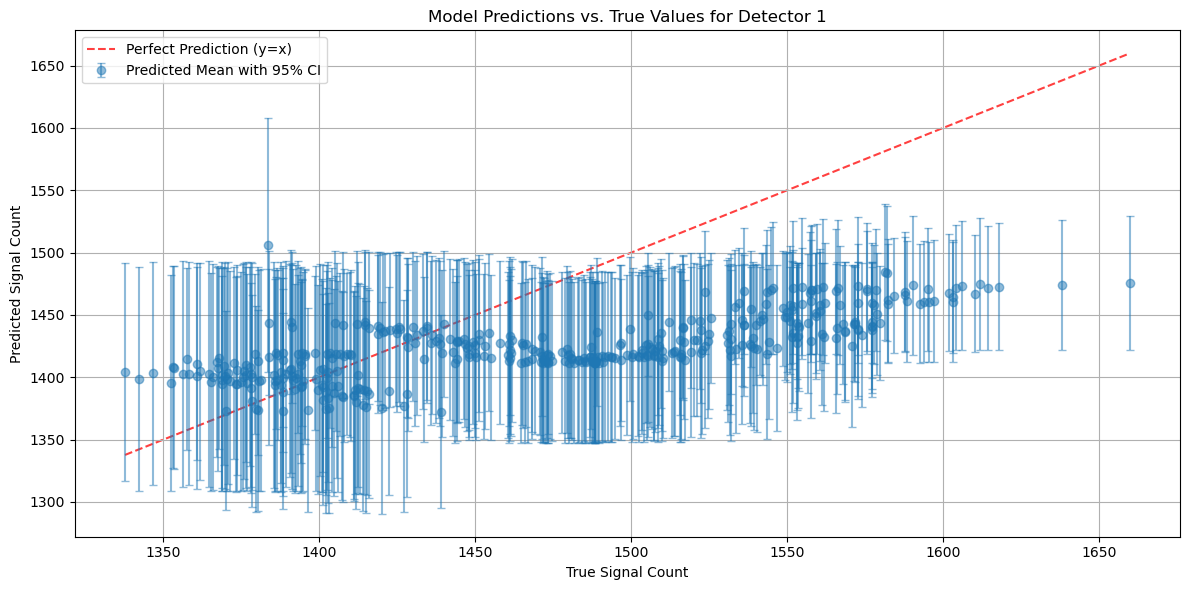

In [22]:
print("\nMaking predictions on the test set...")

predicted_distribution_scaled = model(X_test_scaled)
mean_pred_scaled = predicted_distribution_scaled.mean().numpy()
stddev_pred_scaled = predicted_distribution_scaled.stddev().numpy()

mean_pred_original_scale = scaler_y.inverse_transform(mean_pred_scaled)
stddev_pred_original_scale = stddev_pred_scaled * scaler_y.scale_

mse = mean_squared_error(y_test, mean_pred_original_scale)
print(f"\nMean Squared Error on original scale data: {mse:.2f}")

# --- Visualize the results for the first detector ---
detector_idx = 0 

plt.figure(figsize=(12, 6))
plt.title(f"Model Predictions vs. True Values for Detector {detector_idx + 1}")
plt.xlabel("True Signal Count")
plt.ylabel("Predicted Signal Count")

# Use all points from the test set instead of a random sample
true_vals = y_test[:, detector_idx]
pred_means = mean_pred_original_scale[:, detector_idx]
pred_stddevs = stddev_pred_original_scale[:, detector_idx]

# Plot the uncertainty as error bars
plt.errorbar(
    true_vals,
    pred_means,
    yerr=2 * pred_stddevs, # 2 * std dev is the ~95% confidence interval
    fmt='o',
    alpha=0.5, # Increased alpha for better visibility of all points
    capsize=3,
    label='Predicted Mean with 95% CI'
)

# Plot the y=x line for reference (a perfect model)
lims = [
    min(np.min(true_vals), np.min(pred_means)),
    max(np.max(true_vals), np.max(pred_means)),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction (y=x)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\mikec\AppData\Local\Temp\ipykernel_10636\1612608415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['time_index'] = range(len(merged_df_clean))


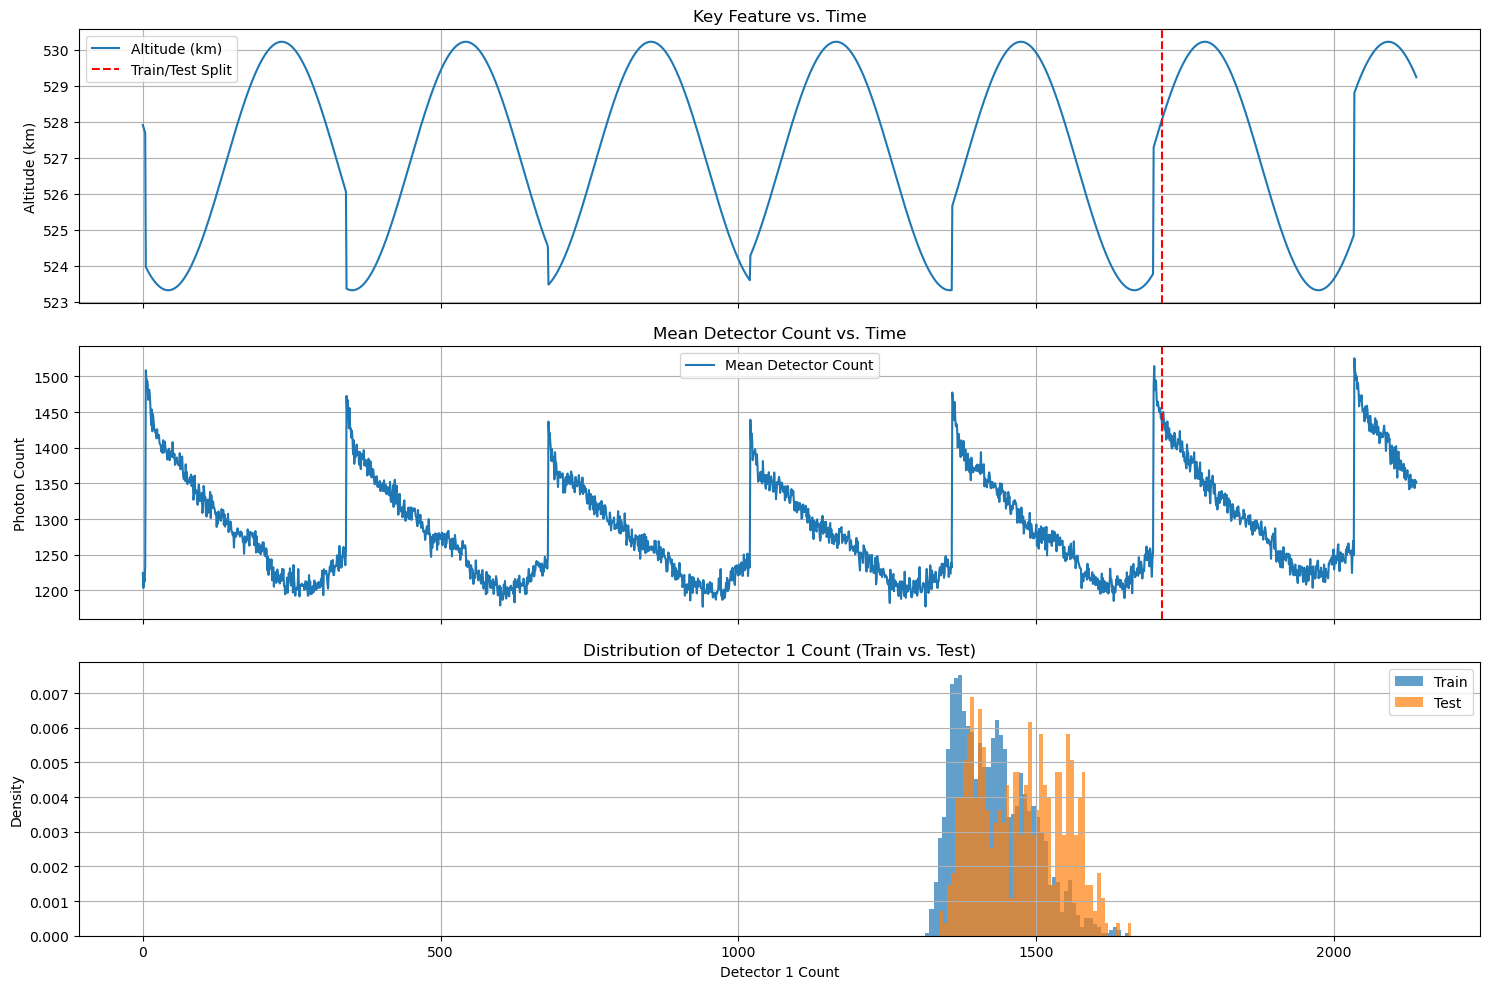

In [23]:
# Add this code after you've created the 'merged_df_clean' dataframe

# Add a simple time index for plotting
merged_df_clean['time_index'] = range(len(merged_df_clean))

# Define the split point for visualization
split_index = int(len(merged_df_clean) * 0.8)

# Create a figure to plot on
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)

# 1. Plot a key feature over time (e.g., altitude)
axes[0].set_title("Key Feature vs. Time")
axes[0].plot(merged_df_clean['time_index'], merged_df_clean['altitude_km'], label='Altitude (km)')
axes[0].axvline(split_index, color='r', linestyle='--', label='Train/Test Split')
axes[0].set_ylabel("Altitude (km)")
axes[0].legend()
axes[0].grid(True)

# 2. Plot the mean of the target variables over time
axes[1].set_title("Mean Detector Count vs. Time")
axes[1].plot(merged_df_clean['time_index'], merged_df_clean[target_cols].mean(axis=1), label='Mean Detector Count')
axes[1].axvline(split_index, color='r', linestyle='--')
axes[1].set_ylabel("Photon Count")
axes[1].legend()
axes[1].grid(True)

# 3. Plot the distribution of a target before and after the split
axes[2].set_title("Distribution of Detector 1 Count (Train vs. Test)")
merged_df_clean.iloc[:split_index]['detector_1'].hist(ax=axes[2], bins=50, density=True, alpha=0.7, label='Train')
merged_df_clean.iloc[split_index:]['detector_1'].hist(ax=axes[2], bins=50, density=True, alpha=0.7, label='Test')
axes[2].set_xlabel("Detector 1 Count")
axes[2].set_ylabel("Density")
axes[2].legend()

plt.tight_layout()
plt.show()